# Visualising the pulsar data and Calculation of the <mark>'Dispersion Measure'</mark>: B0531+21_w2

This notebook visualises the frequency, $v$, vs phase data, $\phi$, recorded from the 42 ft telescope at JBO. 

The dispersion in the data is used to calculate the dispersion mesaure $DM$.

<span style='color: red'>
    Three methods are adopted to calculate the DM: </span><br><br>
    
1. <b>Fitting the peak</b>: The peak of the integrated spectrum is plotted for various DM's and fitted. 
<br><br>
2. <b>Fitting the Spectrum</b>: Every frequency channel is separately considered and the relationship between time delay and frequency is used.
<br><br>
3. <b>Monte Carlo simulation</b>:  Multiple data sets are simulated using Monte Carlo techniques to obtain an accurate DM.

Additionally, an optimization program is also run to obtain the de-dispersed data. 

In [3]:
# Imports and preamble
from __future__ import (print_function, absolute_import, division)
import os
import scipy.optimize as opt

import numpy as np
import scipy

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from scipy.optimize import curve_fit
from scipy import stats
from  matplotlib import pyplot as plt
import matplotlib

from math import pi

%matplotlib inline
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

pulsar_name = 'B0531+21_w3'

## 1. Data Functions

Each section consists of functions, which are used in the analysis, for reading, organizing and plotting the data.

### 1.1 Reading Data

In [4]:
# Get the data directory path
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "Data")
pulsar_meas = os.path.join(data_dir, "PulsarMeasurements")
results_figs = os.path.join(root_dir, "ResultPictures1")

def read_data(file_name):
    """
    Reads the data from ascii files.
    
    @param file_name :: name of the file
    
    @returns :: three arrays with the channel counts,
                phase_counts and data.
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(pulsar_meas, file_name)
    
    chan_count, phase_count, data = \
    np.loadtxt(data_file, usecols=(1,2,3), unpack=True, skiprows=1)
    
    return chan_count, phase_count, data

### 1.2 Organising Data

In [5]:
def get_numbers(chan_count, phase_count):
    """
    Gets the number of channels and the
    number of phase bins of the data.
    
    @param chan_count :: channel counts as read from 
                         the data file
    @param phase_count :: same for phase
    
    @returns :: number of channels and number of phases
    """
    
    nchan=int(chan_count[-1])+1
    nphase=int(phase_count[-1])+1
    
    return nchan, nphase


def reshape_data(nchan, nphase, data):
    """
    Reshapes the data into 2d structure so it is usable.
    
    @param nchan :: number of frequency channels
    @param nphase :: number of phase bins
    @param data :: intensity data
    
    @returns :: 2d data structure, array of channels and
                array of phases
    """
    
    raw = data.reshape(nchan,nphase)
    iphase = phase_count.reshape(nchan,nphase)[0] 
    ichan = chan_count.reshape(nchan,nphase)[:,0]
    
    return raw, ichan, iphase


def freq_integral(raw):
    """
    Takes the data and integrates it over all
    frequency channels.
    
    @param raw :: 2d data structure
    
    @returns :: data integrated along frequency
    """
    
    integrated = np.sum(raw, axis=0)
    
    return integrated


def convert_axis(ichan, iphase):
    """
    Convert the channels of frequency and the phase
    array into physical things.
    
    @param ichan :: array of channels of data
    @param iphase :: array of phases of data
    
    @returns :: array of frequencies and array of times
    """
    
    freq = 605.125 + ichan * (10/nchan)
    time = iphase*(0.033392 /nphase)
    
    return freq, time

### 1.3 Plotting the data

In [6]:
def density_plot(data, freq, time):
    """
    Function that makes a density plot of some data.
    
    @param data :: data of the density plot
    @param freq :: frequencies (y-axis)
    @param time :: times (x-axis)
    
    @returns :: density plot
    """
    
    dens_plot = plt.figure(figsize=(12,7))
    plt.imshow(data, aspect='auto', origin='lower', 
               extent=(time[0],time[-1],freq[0],freq[-1]))
    plt.title(pulsar_name)
    plt.xlabel("Time (s)",)
    plt.ylabel("Frequency (MHz)")
    plt.savefig(results_figs + os.sep + "DensityPlots" + os.sep +
                pulsar_name + ".png")


def intensity_plot(integrated, time):
    """
    Function that makes an intensity plot of some data.
    
    @param integrated :: y-data of the intensity plot
    @param time :: x-data of the intensity plot
  
    @returns :: intensity plot
    """
    
    intens_plot = plt.figure(figsize=(12,7))
    plt.plot(time, integrated, 'b-')
    plt.xlabel("Period (seconds)")
    plt.ylabel("Intensity")
    plt.title(pulsar_name)
    plt.savefig(results_figs + os.sep + "IntegratedProfiles" + os.sep +
                pulsar_name + ".png")

### 2. Dispersion Measure Functions

This section consists of functions used to de-disperse the data, calculate the time delays and to find the $DM$ using optimization.

### 2.1 Shifting

In [7]:
def shift_rows(data_in, nchan, shifts):
    """
    Shifts the rows of the data by amount in variable "shifts".
    
    @param data_in :: data to be shifted
    @param shifts :: amount to be shifted by
    
    @returns :: shifted data
    """
    
    shifted=np.zeros_like(data_in)
    for chan in range(nchan):
        shifted[chan] += np.roll(data_in[chan], -int(shifts[chan]))
    return shifted

def shifting(x, constants):
    """
    Shifts the data by an array times the variable m.
    Tries to dedisperse the data this way.
    
    @param constants :: array of constants i.e. raw_data,
                        freq, nphase
    
    @returns :: negative of the maximum of the integrated frequency
    """
    
    bindelay = (x[0] * 4148.8 * constants[2])/(0.033392 * pow(constants[1], 2))
    dedispersed = shift_rows(constants[0], nchan, bindelay)
    integrated = np.sum(dedispersed, axis=0)
    
    return -np.amax(integrated)


def shifting_results(x, constants):
    """
    Does the same thing as function shifting.
    
    @returns :: the bindelay, dedispersed and integrated
                numpy arrays
    """
    
    bindelay = (x[0] * 4148.8 * constants[2])/(0.033392 * pow(constants[1], 2))
    dedispersed = shift_rows(constants[0], nchan, bindelay)
    integrated = np.sum(dedispersed, axis=0)
    
    return bindelay, dedispersed, integrated

### 2.2 Dispersion Measure Through Optimization

In [8]:
def find_dispersion(shifting, initial_guess, constants):
    """
    Finds the dispersion measure using minimization.
    
    @param initial_guess :: gets the initial guess of the data
    @param shifting :: the shifting function
    @param constants :: array of constants
    
    @returns :: the bindelay, dedispersed and integrated arrays
    """
    
    res = opt.minimize(shifting, [initial_guess], constants, method="Nelder-Mead")
    
    return res.x[0], res.fun

## 3. Kowalski, Analysis.

In [9]:
# Get the needed data
chan_count, phase_count, data = read_data(pulsar_name)
nchan, nphase = get_numbers(chan_count, phase_count)
raw, ichan, iphase = reshape_data(nchan, nphase, data)
integrated = freq_integral(raw)
freq, time = convert_axis(ichan, iphase)

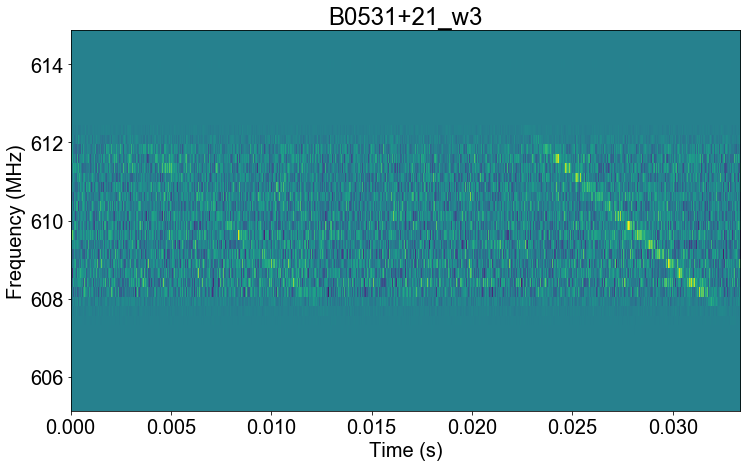

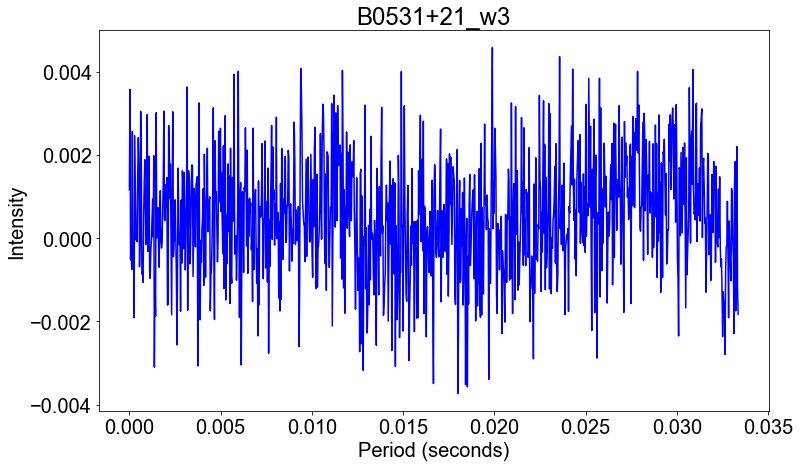

In [10]:
density_plot(raw, freq, time)
intensity_plot(integrated, time)


## 3.1 <mark><u>METHOD 1:</u></mark> Generate Data for Fitting the curve.
<span style='color: red'>
Analysis continued in <b>MATLAB</b>.
</span>

Fitting the below curve and roughly apporximating the DM.

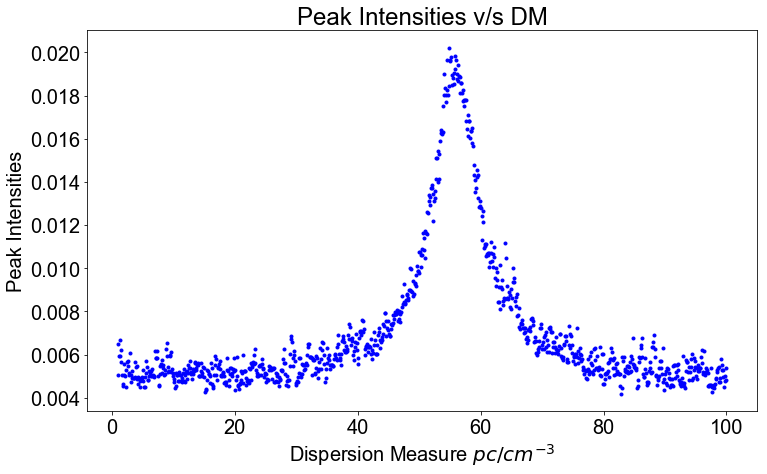

In [11]:
dms = np.linspace(1,100,1000)
intensity_peaks = []
for i, guess in enumerate(dms):
    intensity_peaks.append(-shifting([guess], [raw, freq, nphase, nchan]))

data = np.array([dms, intensity_peaks])
data = np.transpose(data)

np.savetxt(data_dir + os.sep + 'SoumyaData' + os.sep + \
           pulsar_name + '.txt', data, fmt="%.7f")

plt.figure(figsize=(12,7))
plt.plot(data[:,0], data[:,1], 'b.')
plt.xlabel('Dispersion Measure $pc/cm^{-3}$')
plt.ylabel('Peak Intensities')
plt.title('Peak Intensities v/s DM')
plt.show()

## 3.2 Histogram Method

This uses <mark>optimization</mark> to find dm. Needs fine tuning from the user.

In [12]:
# Plot 2D histogram to see where the DM
# value would be
n = 1000
tries = np.linspace(40,80,n)
data = []
for i, init_guess in enumerate(tries):
    disp_measure, function_val = \
    find_dispersion(shifting, init_guess, [raw, freq, nphase, nchan])
    data.append([init_guess, disp_measure, -function_val])

# Export the data for generating gifs in mathematica
data = np.asarray(data)
np.savetxt(data_dir + os.sep + 'Histograms' + os.sep + pulsar_name + '.txt', data)

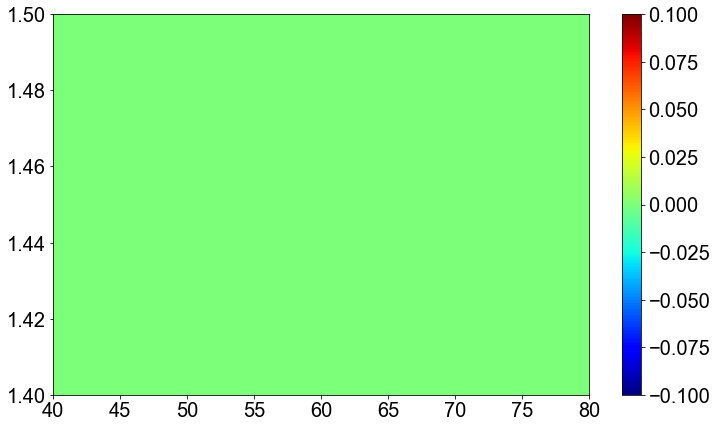

In [13]:
# Plot the thing
plt.figure(figsize=(12,7))
plt.hist2d(data[:,1], data[:,2], 20, range = [[40,80], [1.40, 1.50]], cmap = 'jet')
plt.colorbar()
plt.show()

## 3.3 <mark><u>METHOD 2:</u></mark> Time Delay vs Frequency

<span style='color: red'>
Analysis continued in <b>Mathematica</b>.
</span>


In [14]:
# Save the data to text file for processing in mathematica
freq_delay_dir = os.path.join(data_dir, "FreqDelay")
np.savetxt(freq_delay_dir + os.sep + pulsar_name + "_raw" + ".txt", raw)
np.savetxt(freq_delay_dir + os.sep + pulsar_name + "_time" + ".txt", time)
np.savetxt(freq_delay_dir + os.sep + pulsar_name + "_freq" + ".txt", freq)

## 3.4 <mark><u>METHOD 3:</u></mark> Monte Carlo Method

### I. Functions used for the method

In [15]:
def plot_noise_zoomed(time_, integrated_, ErrNoise_):
    """
    plots the noise in the data and showns the amplitude and standard deviation
    """
    
    # Plots the noise in the date
    plt.figure(figsize=(10,5))
    plt.plot(time_,integrated_, zorder=1)
    plt.hlines(y=0,xmin=time_[0], xmax=time_[-1], colors='r', 
               linestyles='solid', zorder=2)
    plt.hlines(y=ErrNoise_,xmin=time_[0], xmax=time_[-1], colors='r', 
               linestyles= 'dashed', zorder=2)
    plt.hlines(y=-ErrNoise_,xmin=time_[0], xmax=time_[-1], colors='r', 
               linestyles= 'dashed', zorder=2)
    
    plt.xlabel("Period (seconds)")
    plt.ylabel("Intensity (Arbitrary)")
    plt.title("Noise in the Integrated profile")
    axes = plt.gca()
    # If noise is larger, limits need to be changes to estimate upperbound
    axes.set_ylim([-0.1,0.1])
    plt.show()
    
def measure_dm(dms, maxima_arr, params):
    """
    function calculated the dispersion measure for a data set
    
    @param dms: dispersion measure values
    @param maxima_arr: array with the peak intensity points 
    
    @returns final_dm : maximum in the best-fit
    @returns bestfit_maxima : the best-fit array
    @returns des_index : index of the max dm
    """
    # does a Gaussian polyfit and outputs the best-fit values
    def tri_norm(x, *args):
        a1, a2, a3, b1, b2, b3, c1, c2, c3 = args
        ret = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + \
              a3*np.exp(-((x-b3)/c3)**2)
        return ret
    popt, _ = curve_fit(tri_norm, dms, maxima_arr, p0=params)
    bestfit_maxima = tri_norm(dms, *popt)
        
    # finds the dm and appends in an array for all data sets
    max_value = np.amax(bestfit_maxima)
    des_index = np.where(bestfit_maxima == max_value)
    final_dm = dms[des_index]
    return final_dm, bestfit_maxima, des_index


### I. Estimating the mean and standard deviation of the white noise in the data

The noise in the measured data set is plotted and the mean and standard deviation in the noise are measured.

Standard deviation in the noise are 0.0014


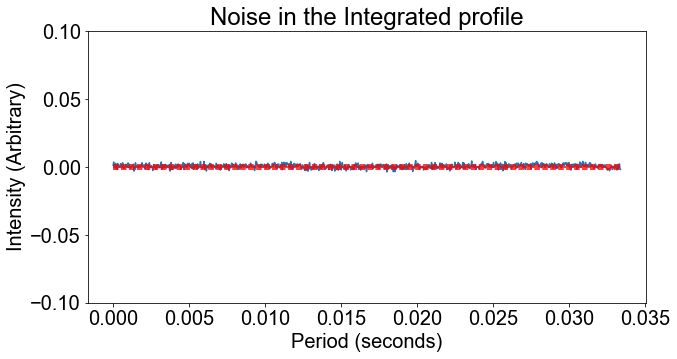

In [16]:
# calculates the noise in the integrated array + estimates the uncertainty
noise = integrated[np.where(integrated < 0.05)]
err_noise = np.std(noise)

time_noise = time[np.where(integrated < 0.05)]

print("Standard deviation in the noise are %.4f"%err_noise)
plot_noise_zoomed(time, integrated, err_noise)

## 4.2 Comparing the simulated noise with noise in the data sets

The randomly generated white noise is compared with the noise in the data. As observed, the nature of the simulated nosie ressembles with the data.

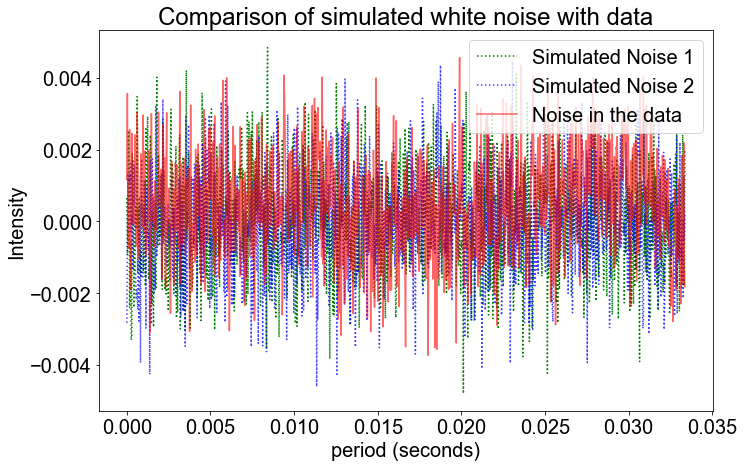

In [17]:
generate_noise = np.random.normal(0, err_noise, size=len(time))
generate_noise1 = np.random.normal(0, err_noise, size=len(time))
generate_noise2 = np.random.normal(0, err_noise, size=len(time))

plt.figure(figsize=(11, 7))
plt.plot(time, generate_noise, 'g:', label='Simulated Noise 1')
plt.plot(time, generate_noise1, 'b:', label='Simulated Noise 2', alpha=0.75)
plt.plot(time_noise, noise, 'r-', label='Noise in the data', alpha=0.6)
plt.legend(loc=1)
plt.xlabel('period (seconds)')
plt.ylabel('Intensity')
plt.title('Comparison of simulated white noise with data')
plt.show()

## 4.3 Adding the simulated noise to data 

In [18]:
# generated 100 data sets of pure white noise
data = [0]*100
for i in range(100):
    data[i] = np.random.normal(0, err_noise, size=len(time))    

In [19]:
# computes the "peak intensities vs dm" for each new data set (with added noise)
peak_vals = []
maxima = [0]*100

for j in range(1, 100):
    for dm in range(0, len(dms)):
        _, _, int_profile = shifting_results([dms[dm]], [raw, freq, nphase, nchan]) 
        new_int_profile = int_profile + data[j]
        peak_vals.append(np.amax(new_int_profile))
    maxima[j] = peak_vals[-1000:]  

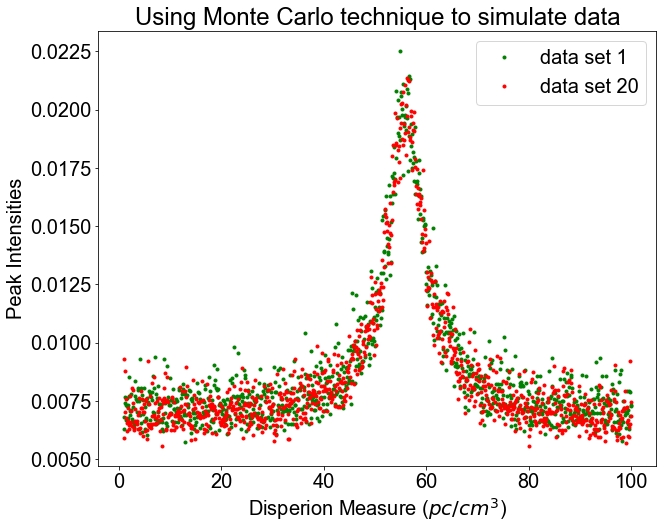

In [20]:
# plots the results for two arbitary data set to demonstrate the effect of noise addition
plt.figure(figsize=(10,8))
plt.xlabel('Disperion Measure ($pc/{cm}^3$)')
plt.ylabel('Peak Intensities')
plt.plot(dms, maxima[1],'g.', label='data set 1')
plt.plot(dms, maxima[20], 'r.', label='data set 20')
plt.title('Using Monte Carlo technique to simulate data')
plt.legend()
plt.show()

## 4.4 Mesuring the DM for each data set 

In [21]:
dms_ = dms[400:800]

In [22]:
dm_val = []

parameters = [0.009427, 0.00996,  -0.001652,
              55.73, 58.91, 69.19,
              3.94, 25.93, 6.008]
      
for j in range(1, 100):
    maxima[j] = maxima[j][400:800]
    dm, _, _ = measure_dm(dms_, maxima[j], parameters)
    dm_val.append(dm)
mean_dm = np.mean(dm_val)   
std_dm = np.std(dm_val)

print('The DM for the pulsar is %.4f ± %.4f'%(mean_dm, std_dm)) 

The DM for the pulsar is 55.8749 ± 0.0766


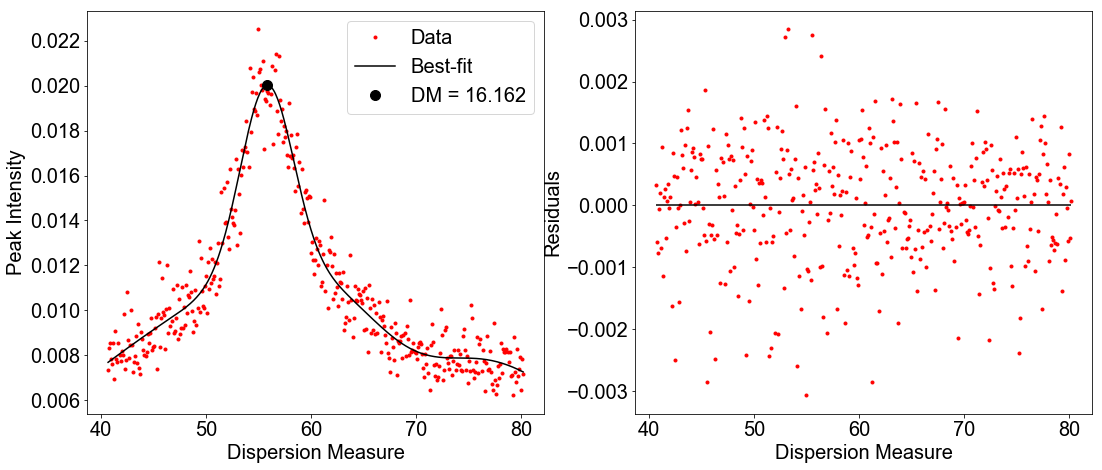

In [23]:
dm_for_1, bestfit_maxima, des_index = measure_dm(dms_, maxima[1], parameters)

plt.figure(figsize=(18,7))
plt.subplot(121)
plt.plot(dms_, maxima[1], 'r.', label='Data')
plt.plot(dms_, bestfit_maxima, 'k-', label='Best-fit')
plt.plot(dms_[des_index], bestfit_maxima[des_index], 'ko', markersize=10, 
         label='DM = %.3f'%dms[des_index])
plt.legend()
plt.xlabel('Dispersion Measure')
plt.ylabel('Peak Intensity')

plt.subplot(122)
plt.plot(dms_, bestfit_maxima-maxima[1], 'r.')
plt.hlines(y=0,xmin=dms_[0], xmax=dms_[-1], colors='k', 
               linestyles='solid', zorder=100)
plt.xlabel('Dispersion Measure')
plt.ylabel('Residuals')
plt.subplots_adjust(bottom=0.1, top=0.9)
plt.show()